In [ ]:
87import numpy as np
from copy import deepcopy

LENGTH = 3
NUM_ROWS = LENGTH
NUM_COLS = LENGTH
NUM_STATES = 3**(NUM_ROWS*NUM_COLS) # Num states can be x,o or empty for each position in the board

class Environment:
	def __init__(self, length_r = NUM_ROWS, length_c = NUM_COLS,print_board=False):
		self.board = np.zeros((length_r,length_c)); # Game board, init as empty
		self.x = -1 # player 1
		self.o = 1 # player 2
		self.winner = None
		self.ended = False
		self.print_board = print_board # Defines if board is printed doring games

	def is_empty(self,i,j):
		return self.board[i,j] == 0

	def reward(self, player):
		if not self.ended or self.winner is None:
			return 0
		elif self.winner == player:
			return 1
		else:
			return -1

	def get_state(self):
		# returns the current state, represented as an int
		cell = 0
		state = 0

		for i in range(NUM_ROWS):
			for j in range(NUM_COLS):
				if self.board[i,j] == self.x:
					val = 1
				elif self.board[i,j] == self.o:
					val = 2
				else:
					val = 0

				state += (3^cell)*val
				cell+=1

		return state

	def is_game_over(self, recalculate=False):
		if not recalculate and self.ended:
			return self.ended
		# check rows
		for i in range(NUM_ROWS):
			for player in (self.x, self.o):
				if self.board[i].sum() == player*NUM_ROWS:
					self.winner = player
					self.ended = True
					return True

		# check columns
		for j in range(NUM_COLS):
			for player in (self.x, self.o):
				if self.board[:,j].sum() == player*NUM_COLS:
					self.winner = player
					self.ended = True
					return True

		# check diagonals
		for player in (self.x, self.o):
		  # top-left -> bottom-right diagonal
			if self.board.trace() == player*LENGTH:
				self.winner = player
				self.ended = True
				return True
		  # top-right -> bottom-left diagonal
			if np.fliplr(self.board).trace() == player*LENGTH:
				self.winner = player
				self.ended = True
				return True

		# check if draw
		if np.all((self.board == 0) == False):
		  # winner stays None
			self.winner = None
			self.ended = True
			return True

		# game is not over
		self.winner = None
		return False

	def is_draw(self):
		return self.ended and self.winner is None

	def draw_board(self):
		print()
		for i in range(NUM_ROWS):
			for j in range(NUM_COLS):
				# Print column dividers
				if j > 0:
					print('|',end='')

				# Gets each block value
				if self.board[i,j] == self.x:
					print('X',end='')
				elif self.board[i,j] == self.o:
					print('O',end='')
				else:
					print(' ',end='')

			# Prints line divider
			if i < NUM_ROWS-1:
				print()
				print('-+-+-')

		print()

	def play_game(self,p1,p2):
		current_player = None
		#loop until game is over
		while not self.is_game_over():
			if current_player == p1:
				current_player = p2
			else:
				current_player = p1

			if self.print_board: # draw the board before the player's action
				self.draw_board()

			# takes action
			current_player.take_action(env=self)

			# update state history for both players
			state = self.get_state()
			p1.update_state_history(state)
			p2.update_state_history(state)

		if self.print_board: # draw the final state of the board
			self.draw_board()

		# updates value function
		p1.update_value_function(env=self)
		p2.update_value_function(env=self)

		if self.print_board:
			print()
			if self.winner is None:
				print("It is a draw!")
			elif self.winner == self.x:
				print("X player won!")
			else:
				print("O player won!")
			print()

class Agent:
	def __init__(self, sym = 1, eps=0.1, alpha=0.8, states_results=None):
		self.eps = eps # probability of choosing random action
		self.alpha = alpha # learning rate
		self.state_history = []
		self.sym = sym
		if states_results is not None:
			self.init_value_function(states_results)

	def set_eps(self,eps):
		self.eps = eps

	def init_value_function(self, states_results):
		# initialize value function
		# states_results is an array of state_winner_tripples
		self.value_fun = np.zeros(NUM_STATES)

		for state, ended, winner in states_results:
			val = 0
			if ended:
				if winner == self.sym:
					val = 1
				elif winner is None:
					val = 0.5
				else:
					val = -1
			else:
				val = 0

			self.value_fun[state] = val

		return self.value_fun

	def update_value_function(self, env):
		# we want to BACKTRACK over the states, so that:
		# V(prev_state) = V(prev_state) + alpha*(V(next_state) - V(prev_state))
		# where V(next_state) = reward if it's the most current state
		#
		# NOTE: we ONLY do this at the end of an episode

		if not env.ended:
			return

		reward = env.reward(self.sym)
		value = reward
		for prev in reversed(self.state_history):
			self.value_fun[prev] += self.alpha*(value - self.value_fun[prev])
			value = self.value_fun[prev]
		self.reset_history()

	def reset_history(self):
		self.state_history = []

	def update_state_history(self, state):
		# cannot put this in take_action, because take_action only happens
		# once every other iteration for each player
		# state history needs to be updated every iteration
		# s = env.get_state() # don't want to do this twice so pass it in
		self.state_history.append(state)

	def take_action(self,env):
		if env.print_board:
			print()
			print('Agent action:')
		# choose an action based on epsilon-greedy strategy
		r = np.random.rand()
		best_move = None # It is the number corresponding to the best next stage

		# get all possible valid actions
		valid_actions = []
		for i in range(NUM_ROWS):
			for j in range(NUM_COLS):
				if env.is_empty(i,j): # If cell is empty then it is a valid action
					valid_actions.append((i,j))

		action = None
		if r < self.eps: # takes a random action
			# Chooses a random action based on the possible available actions
			idx = np.random.choice(len(valid_actions))
			action = valid_actions[idx]

		else:
			# choose the best action based on current values of states
			# loop through all possible moves, get their values
			# keep track of the best value
			best_value = -10000
			for val_act in valid_actions:
				env.board[val_act[0],val_act[1]] = self.sym
				state = env.get_state()
				env.board[val_act[0],val_act[1]] = 0

				if self.value_fun[state] > best_value:
					action = val_act
					best_value = self.value_fun[state]
					best_move = state

		# takes the action
		if action is not None:
			env.board[action[0],action[1]] = self.sym

class Random_Action_Player:
	def __init__(self,sym):
		self.sym = sym

	def take_action(self, env):
		# get all possible valid actions
		valid_actions = []
		for i in range(NUM_ROWS):
			for j in range(NUM_COLS):
				if env.is_empty(i,j): # If cell is empty then it is a valid action
					valid_actions.append((i,j))

		idx = np.random.choice(len(valid_actions))
		action = valid_actions[idx]
		env.board[action[0],action[1]] = self.sym

	def update_value_function(self, env):
		pass

	def update_state_history(self, state):
		pass

class Default_Player:
	def __init__(self,sym):
		self.sym = sym

	def take_action(self, env):
		while True:
			# break if we make a legal move
			print()
			move = input("Enter coordinates i,j for your next move (i,j=[0...2]): ")
			i, j = move.split(',')
			i = int(i)
			j = int(j)
			if env.is_empty(i, j):
				env.board[i,j] = self.sym
				break
			else:
				print()
				print('Move is invalid. Type the coordinates (i,j) of an empty cell in the board.')

	def update_value_function(self, env):
		pass

	def update_state_history(self, state):
		pass

# Gets initial values for every possible state
def get_initial_states_results(env, i=0, j=0):
	# recursive function that will return all
	# possible states (as ints) and who the corresponding winner is for those states (if any)

	results = [] # results as an array of state_winner_triples

	for val in (0,env.x,env.o):
		env.board[i,j] = val

		if j == NUM_COLS - 1:
			# if j = NUM_COLS and i < NUM_ROWS then j=0 and i+=1
			if i == NUM_ROWS - 1:
				# break point
				# get the results for a state
				state = env.get_state()
				ended = env.is_game_over(recalculate=True)
				winner = env.winner
				results.append((state,ended,winner))
			else:
				results += get_initial_states_results(env, i+1, 0)
		else:
			results += get_initial_states_results(env, i, j+1)

	return results


if __name__ == '__main__':
	# init the environment
	e = Environment()

	# get state values before training
	states_results = get_initial_states_results(Environment())

	# init the players as agents
	a1 = Agent(eps = 1, sym = e.x, states_results=states_results)
	a2 = Agent(sym = e.o, states_results=states_results)

	print('Training Agent...')
	print()
	T = 50000 # number of games that will be played for training
	for t in range(T):
		if t%800==0:
			print('Training: {}% Complete'.format(t*100/T))

		if t < 1000: # min eps=0.01
			a1.set_eps(1/(t+1))
			a2.set_eps(1/(t+1))

		Environment().play_game(a1,a2)

	print('Training Complete')
	print()

	a1.set_eps(0)
	a2.set_eps(0)

	print('Begining validation of the agent trained by pairing it to an agent with a random approach...')
	print()

	rand_p = Random_Action_Player(e.o)

	G = 1000 # Number of games played for validation
	agent_wins = 0
	rand_player_wins = 0
	draws = 0
	for g in range(G):
		val_env = Environment()
		val_env.play_game(a1,rand_p)

		if val_env.winner == a1.sym:
			agent_wins += 1
		elif val_env.winner == rand_p.sym:
			rand_player_wins += 1
		else:
			draws += 1

	print('Validation results:')
	print('Trained Agent Wins: {}%;     Random Action Player Wins: {}%;      Draws:{}%'.format(agent_wins*100/G,rand_player_wins*100/G,draws*100/G))

	# print('Begining game against human player. Human is "X", angent is "O":')
	# print()

	# human = Default_Player(e.o)

	# while True:
	# 	Environment(print_board=True).play_game(a1,human)
	# 	print()
	# 	answer = input("Play again? [y/n]: ")
	# 	if answer and answer.lower()[0] == 'n':
	# 		break

Training Agent...

Training: 0.0% Complete
Training: 1.6% Complete
Training: 3.2% Complete
Training: 4.8% Complete
Training: 6.4% Complete
Training: 8.0% Complete
Training: 9.6% Complete
Training: 11.2% Complete
Training: 12.8% Complete
Training: 14.4% Complete
Training: 16.0% Complete
Training: 17.6% Complete
Training: 19.2% Complete
Training: 20.8% Complete
Training: 22.4% Complete
Training: 24.0% Complete
Training: 25.6% Complete
Training: 27.2% Complete
Training: 28.8% Complete
Training: 30.4% Complete
Training: 32.0% Complete
Training: 33.6% Complete
Training: 35.2% Complete
Training: 36.8% Complete
Training: 38.4% Complete
Training: 40.0% Complete
Training: 41.6% Complete
Training: 43.2% Complete
Training: 44.8% Complete
Training: 46.4% Complete
Training: 48.0% Complete
Training: 49.6% Complete
Training: 51.2% Complete
Training: 52.8% Complete
Training: 54.4% Complete
Training: 56.0% Complete
Training: 57.6% Complete
Training: 59.2% Complete
Training: 60.8% Complete
Training: 62.

In [ ]:
import numpy as np
import random

# Grid size
grid_size = 5

goal = (4, 4)

def generate_obstacle(grid_size, goal, start=(0, 0)):
    while True:
        obstacle = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
        if obstacle != goal and obstacle != start:
            return obstacle

# Initialize environment
obstacle = generate_obstacle(grid_size, goal)

def get_reward(state):
    if state == goal:
        return 10
    elif state == obstacle:
        return -5
    return -1  # Penalty for each move

def get_possible_actions(state):
    x, y = state
    actions = []
    if x > 0:
        actions.append((-1, 0))  # Left
    if x < grid_size - 1:
        actions.append((1, 0))  # Right
    if y > 0:
        actions.append((0, -1))  # Down
    if y < grid_size - 1:
        actions.append((0, 1))  # Up
    return actions

# Q-learning parameters
epsilon = 0.1  # Exploration factor
alpha = 0.5    # Learning rate
gamma = 0.9    # Discount factor

# Initialize Q-table
Q_table = {}
for x in range(grid_size):
    for y in range(grid_size):
        Q_table[(x, y)] = {(dx, dy): 0 for dx, dy in get_possible_actions((x, y))}

# Training parameters
episodes = 1000

for episode in range(episodes):
    state = (0, 0)  # Start position
    while state != goal:
        if random.uniform(0, 1) < epsilon:
            action = random.choice(list(Q_table[state].keys()))  # Exploration
        else:
            action = max(Q_table[state], key=Q_table[state].get)  # Exploitation

        next_state = (state[0] + action[0], state[1] + action[1])
        reward = get_reward(next_state)

        # Q-value update
        if next_state in Q_table:
            Q_table[state][action] += alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][action])
        else:
            Q_table[state][action] += alpha * (reward - Q_table[state][action])

        if next_state == obstacle:
            break  # Stop episode if obstacle is hit

        state = next_state  # Move to next state

# Testing the learned policy
state = (0, 0)
path = [state]
while state != goal:
    action = max(Q_table[state], key=Q_table[state].get)
    state = (state[0] + action[0], state[1] + action[1])
    path.append(state)
    if state == obstacle:
        break  # Stop if hitting the obstacle

print("Optimal path:", path)


Optimal path: [(0, 0), (1, 0), (1, 1), (2, 1), (3, 1), (3, 2), (3, 3), (4, 3), (4, 4)]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

k=10
num_problems = 2000

q_star = np.random.normal(0,1, (num_problems,k))
arms = [0] * k

for i in range(10):
  arms[i] = np.random.normal(q_star[0,i], 1, num_problems)



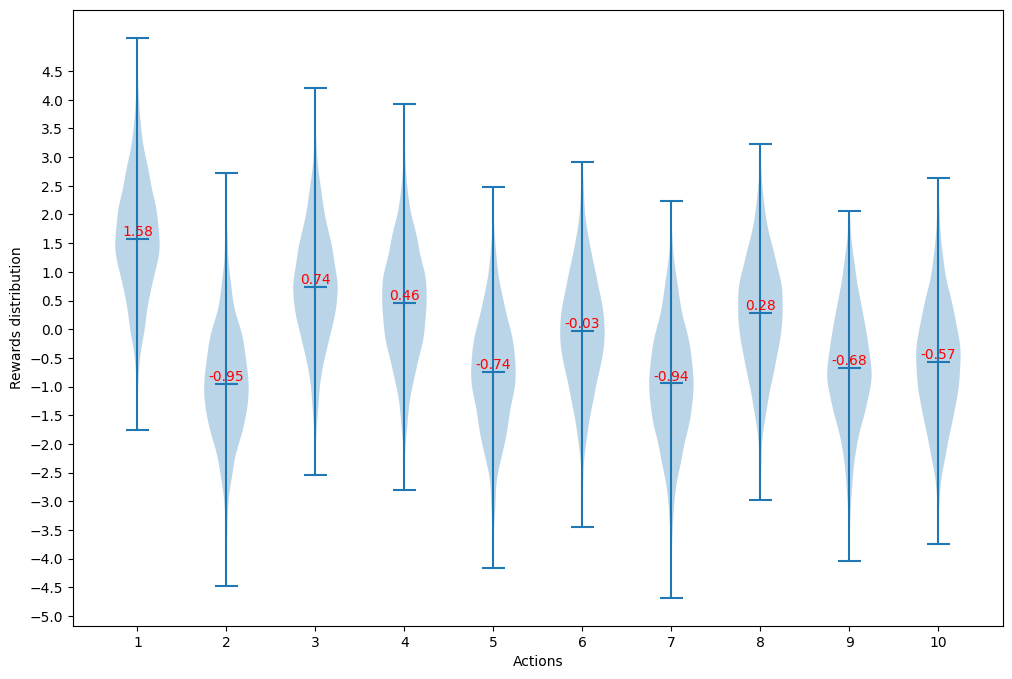

In [ ]:
plt.figure(figsize=(12, 8))
plt.ylabel('Rewards distribution')
plt.xlabel('Actions')
plt.xticks(range(1, 11))
plt.yticks(np.arange(-5, 5, 0.5))

# Violin plot
plt.violinplot(arms, positions=range(1, 11), showmedians=True)

# Compute and annotate medians
medians = [np.median(arms[i]) for i in range(10)]
for i, median in enumerate(medians, start=1):
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom', fontsize=10, color='red')

# Show plot
plt.show()

In [ ]:
def bandit(action, problems):
  return np.random.normal(q_star[problems,action], 1)


In [ ]:
def simple_max(Q, N, t):
  return np.random.choice(np.flatnonzero(Q==Q.max()))

In [ ]:
def simple_bandit(k, epsilon, steps, initial_Q, alpha=0, argmax_func=simple_max):
  rewards = np.zeros(steps)
  actions = np.zeros(steps)
  for i in tqdm(range(num_problems)):
    Q = np.ones(k)
    N = np.zeros(k)
    best_action = np.argmax(q_star[i])
    for t in range(steps):
      if np.random.rand() < epsilon:
        a = np.random.randint(k)
      else:
        a = argmax_func(Q, N, t)
      reward = bandit(a, i)
      N[a] += 1
      if alpha > 0:
          Q[a] = Q[a] + (reward - Q[a]) * alpha
      else:
          Q[a] = Q[a] + (reward - Q[a]) / N[a]
      rewards[t] += reward
      if a == best_action:
          actions[t] += 1
  return np.divide(rewards, num_problems), np.divide(actions, num_problems)

In [ ]:
ep_0, ac_0 = simple_bandit(k=10, epsilon=0, steps=1000, initial_Q=0)
ep_01, ac_01 = simple_bandit(k=10, epsilon=0.1, steps=1000, initial_Q=0)
ep_1, ac_1 = simple_bandit(k=10, epsilon=0.01, steps=1000, initial_Q=0)

100%|██████████| 2000/2000 [01:34<00:00, 21.13it/s]


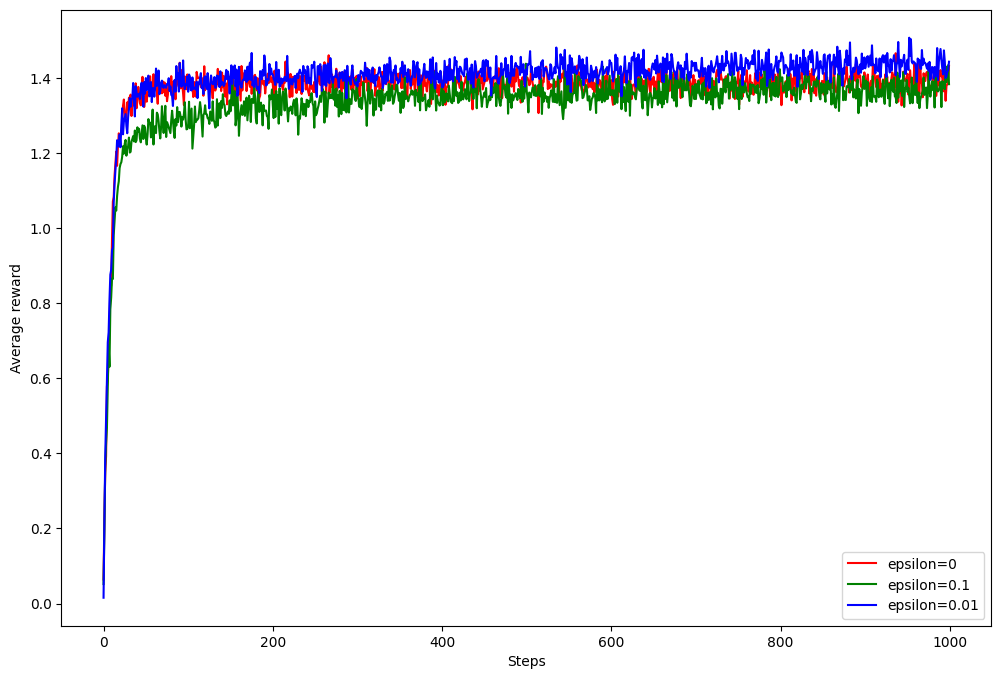

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(ep_0, 'r' ,label='epsilon=0')
plt.plot(ep_01, 'g', label='epsilon=0.1')
plt.plot(ep_1, 'b', label='epsilon=0.01')
plt.ylabel('Average reward')
plt.xlabel('Steps')
plt.legend()
plt.show()

In [ ]:
def ucb(Q, N, t):
  C = 2
  if N.min()  == 0:
    return np.random.choice(np.flatnonzero(N==N.min()))
    M = Q + C * np.sqrt(np.divide(np.log(t), N))
    return np.armax(M)


In [ ]:
ucb_2, ac_ucb_2 = simple_bandit(k = 10, epsilon=0, steps=1000, initial_Q=0, argmax_func=ucb)

NameError: name 'simple_bandit' is not defined

In [ ]:
def softmax(x):
  e_x =np.exp(x-np.max(x))
  M=e_x / e_x.sum()
  return np.argmax(M),M

In [ ]:
def gradient_bandit(k, steps, alpha, initial_Q, is_baseline=True):
  rewards = np.zeros(steps)
  actions = np.zeros(steps)
  for i in tqdm(range(num_problems)):
    Q = np.zeros(k) * initial_Q
    N = np.zeros(k)
    R = np.zeros(k)
    H = np.zeros(k)
    pi = np.zeros(k)
    best_action = np.argmax(q_star[i])
    for t in range(steps):
      a, pi = softmax(H)
      reward = bandit(a, i)
      N[a] += 1
      Q[a] = Q[a] + (reward - Q[a]) / N[a]
      for action_i in range(k):
        if action_i == a:
          H[a] = H[a] + alpha * (reward - R[a]) * (1 - pi[a])
        else:
          H[action_i] = H[action_i] - alpha * (reward - R[action_i] * pi[action_i])
      if is_baseline == True:
        R[a] = Q[a]
      rewards[t] += reward
      if a == best_action:
        actions[t] += 1
  return np.divide(rewards, num_problems), np.divide(actions, num_problems)



In [ ]:
sft_4, ac_sft_4 = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q=0, is_baseline=False)
sft_4_bl, ac_sft_4_bl = gradient_bandit(k=10, steps=1000, alpha=0.4, initial_Q=0, is_baseline=True)

100%|██████████| 2000/2000 [01:40<00:00, 19.97it/s]


In [ ]:
sft_1,ac_sft_1 = gradient_bandit(k=10,steps=1000,alpha=0.1,initial_Q=0,is_baseline=False)
sft_1_bl,ac_sft_1_bl = gradient_bandit(k=10,steps=1000,alpha=0.1,initial_Q=0,is_baseline=True)

100%|██████████| 2000/2000 [01:31<00:00, 21.77it/s]


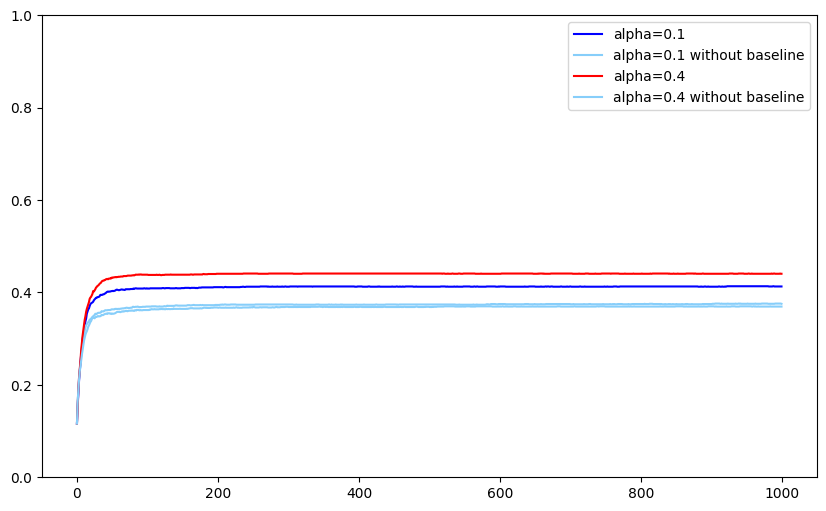

In [ ]:
plt.figure(figsize=(10, 6))
plt.ylim([0,1])
plt.plot(ac_sft_4_bl, 'b', label='alpha=0.1')
plt.plot(ac_sft_4, 'lightskyblue', label='alpha=0.1 without baseline')
plt.plot(ac_sft_1_bl, 'r', label='alpha=0.4')
plt.plot(ac_sft_1, 'lightskyblue', label='alpha=0.4 without baseline')
plt.legend()
plt.show()


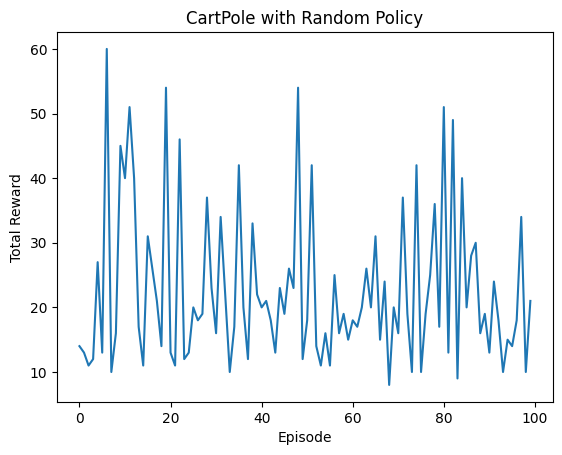

In [2]:
import gym

import numpy as np

import matplotlib.pyplot as plt

def random_policy(state):

    """Returns a random action (0 or 1)"""

    return np.random.choice([0, 1])

def run_cartpole_random(num_episodes=100):

    """Runs CartPole environment with a random policy"""

    env = gym.make('CartPole-v1')

    rewards_per_episode = []

    for episode in range(num_episodes):

        state = env.reset()

        done = False

        total_reward = 0

        while not done:

            action = random_policy(state)  # Random policy selects an action

            state, reward, done, _ = env.step(action)

            total_reward += reward

        rewards_per_episode.append(total_reward)

    env.close()

    return rewards_per_episode

# Run the random policy and plot results

rewards = run_cartpole_random()

plt.plot(rewards)

plt.xlabel("Episode")

plt.ylabel("Total Reward")

plt.title("CartPole with Random Policy")

plt.show()



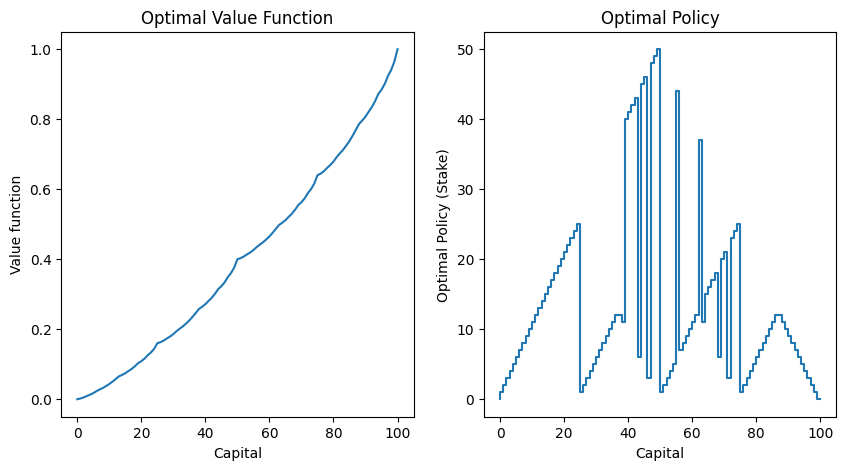

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def gambler_value_iteration(p=0.4, N=100, theta=1e-9, gamma=1.0):
    V = np.zeros(N + 1)
    V[N] = 1  # Terminal state

    while True:
        delta = 0
        for s in range(1, N):
            action_values = []
            for a in range(1, min(s, N - s) + 1):
                value = p * V[s + a] + (1 - p) * V[s - a]
                action_values.append(value)

            max_value = max(action_values)
            delta = max(delta, abs(max_value - V[s]))
            V[s] = max_value

        if delta < theta:
            break

    policy = np.zeros(N + 1)
    for s in range(1, N):
        action_values = []
        for a in range(1, min(s, N - s) + 1):
            action_values.append(p * V[s + a] + (1 - p) * V[s - a])
        policy[s] = np.argmax(action_values) + 1  # Best action

    return V, policy

# Run value iteration and plot results
N = 100
V, policy = gambler_value_iteration(p=0.4, N=N)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(V)
plt.xlabel("Capital")
plt.ylabel("Value function")
plt.title("Optimal Value Function")

plt.subplot(1, 2, 2)
plt.step(range(N + 1), policy)
plt.xlabel("Capital")
plt.ylabel("Optimal Policy (Stake)")
plt.title("Optimal Policy")
plt.show()


In [4]:
import random

def pole_balancing(angle):
    """Decides whether to move left or right based on pole angle."""
    if angle < -5:
        action = "Move Left"
    elif angle > 5:
        action = "Move Right"
    else:
        action = "Stay"
    return action

# Simulate pole angles randomly
for _ in range(10):
    angle = random.randint(-10, 10)  # Random tilt angle between -10 and 10
    action = pole_balancing(angle)
    print(f"Pole Angle: {angle}° → Action: {action}")


Pole Angle: -5° → Action: Stay
Pole Angle: -6° → Action: Move Left
Pole Angle: -1° → Action: Stay
Pole Angle: 9° → Action: Move Right
Pole Angle: -1° → Action: Stay
Pole Angle: 7° → Action: Move Right
Pole Angle: -1° → Action: Stay
Pole Angle: 0° → Action: Stay
Pole Angle: 10° → Action: Move Right
Pole Angle: -8° → Action: Move Left
